In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision.utils as vutil

import matplotlib.pyplot as plt
import numpy as np
import os
os.mkdir('./temp3')
os.mkdir('./net')

%matplotlib inline

In [2]:
image_size = 28
input_dim = 100
num_channels = 1
num_features = 64
batch_size = 64

use_cuda = torch.cuda.is_available()

dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
itype = torch.cuda.LongTensor if use_cuda else torch.LongTensor

train_dataset = dsets.MNIST(root = "./data",
                            train = True,
                            transform = transforms.ToTensor(),
                            download = True)

test_dataset = dsets.MNIST(root = "./data",
                           train = False,
                           transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

indices = range(len(test_dataset))
indices_val = indices[:5000]
indices_test = indices[5000:]

sampler_val = torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test = torch.utils.data.sampler.SubsetRandomSampler(indices_test)

validation_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                                batch_size = batch_size,
                                                sampler = sampler_val)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          sampler = sampler_test)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


## 一、生成器预测图像模型

在这个模型中，我们根据输入的手写数字生成一张图像，并让这个图像与数据中的样本图像尽可能一致

In [3]:
class ModelG(nn.Module):
    def __init__(self):
        super(ModelG, self).__init__()
        self.model = nn.Sequential() #model为一个内嵌的序列化的神经网络模型
        
        # 利用add_module增加一个反卷积层，输入为input_dim维，输出为2*num_features维，窗口大小为5，padding是0
        # 输入图像大小为1，输出图像大小为W'=(W-1)S-2P+K+P'=(1-1)*2-2*0+5+0=3, 5*5
        self.model.add_module('deconv1',nn.ConvTranspose2d(input_dim, num_features*2, 5, 2, 0, bias=False))
        self.model.add_module('bnorm1',nn.BatchNorm2d(num_features*2))
        self.model.add_module('relu1',nn.ReLU(True))
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口5，padding=0
        # 输入图像大小为5，输出图像大小为W'=(W-1)S-2P+K+P'=(5-1)*2-2*0+5+0=13, 13*13
        self.model.add_module('deconv2',nn.ConvTranspose2d(num_features*2, num_features, 5, 2, 0, bias=False))
        self.model.add_module('bnorm2', nn.BatchNorm2d(num_features))
        self.model.add_module('relu2',nn.ReLU(True))
        # 增加第二层反卷积层，输入2*num_features维，输出num_features维，窗口4，padding=0
        # 输入图像大小为13，输出图像大小为W'=(W-1)S-2P+K+P'=(13-1)*2-2*0+4+0=28, 28*28
        self.model.add_module('deconv3',nn.ConvTranspose2d(num_features, num_channels, 4, 2, 0,bias=False))
        self.model.add_module('sigmoid',nn.Sigmoid())
        
    
    def forward(self, input):
        output = input
        for name, module in self.model.named_children():
            output = module(output)
        return(output) # 28*28
    
    
def weight_init(m):
    #模型参数初始化．
    #默认的初始化参数卷积核的权重是均值大概为0，方差在10^{-2}. BatchNorm层的权重均值是大约0.5，方差在0.2左右
    #使用如下初始化方式可以，可以让方差更小，使得收敛更快
    class_name=m.__class__.__name__
    if class_name.find('conv')!=-1:
        print("conv normalization")
        m.weight.data.normal_(0, 0.02)
    if class_name.find('norm')!=-1:
        print("norm normalization")
        m.weight.data.normal_(1.0,0.02)
def make_show(img):
    # 将张量变成可以显示的图像
    img = img.data.expand(batch_size, 3, image_size, image_size)
    return img
def imshow(inp, title=None, ax=None):
    # 在屏幕上绘制图像
    if inp.size()[0] > 1:
        inp = inp.numpy().transpose((1, 2, 0))
    else:
        inp = inp[0].numpy()
    mvalue = np.amin(inp)
    maxvalue = np.amax(inp)
    if maxvalue > mvalue:
        inp = (inp - mvalue)/(maxvalue - mvalue)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)

## 二、生成器 － 识别器模型

在这个模型中，我们不改变生成器，但是改变了网络的目标函数。我们加入了一个识别器，它通过固定值的方式迁移自一个手写体识别器
然后让生成器生成图像，并让识别器进行识别，将识别的误差作为目标函数，调整生成器，从而能给出正确的分类标签

## 三、DCGAN

同样的生成器，根据输入的一个随机噪声向量生成手写数字的图像，然后再同时训练一个辨别器，它的任务就是负责辨别一张输入的图像是来源于生成器
造假还是来源于原始的数据文件。我们将两个网络一起训练。值得注意的是，辨别器和生成器的目标函数是反的。

具体训练步骤：

1、读取一个batch的原始数据，将图像喂给辨别器，辨别器应该输出为真，计算误差：D_x，

2、用随机噪声输入生成器，生成器创造一个batch的假图片，将这些图片输入给辨别器，辨别器应该输出为假，计算误差D_x2

3、将两个误差和起来，反向传播训练辨别器

4、通过生成图像计算误差，对生成器进行反向传播更新梯度

### 绘制特征图

In [4]:
# 构造判别器
class ModelD(nn.Module):
    def __init__(self):
        super(ModelD, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('conv1', nn.Conv2d(num_channels, num_features, 5, 2, 0, bias=False))
        self.model.add_module('relu1', nn.ReLU())
        self.model.add_module('conv2', nn.Conv2d(num_features, num_features*2, 5, 2, 0, bias=False))
        self.model.add_module('bnorm2', nn.BatchNorm2d(num_features * 2))
        self.model.add_module('linear1', nn.Linear(num_features*2*4*4, num_features))
        self.model.add_module('linear2', nn.Linear(num_features, 1))
        self.model.add_module('sigmoid', nn.Sigmoid())
        
    def forward(self, input):
        output = input
        for name, module in self.model.named_children():
            if name == 'linear1':
                output = output.view(-1, num_features * 2* 4 * 4)
            output = module(output)
        return output

In [5]:
netG = ModelG().cuda() if use_cuda else ModelG()
netG.apply(weight_init)
print(netG)

netD = ModelD().cuda() if use_cuda else ModelD()
netD.apply(weight_init)

# 要优化两个网络，所以需要有两个优化器
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5,0.999))

# 生成一个随机噪声输入给生成器
noise=torch.tensor((batch_size, input_dim, 1, 1), dtype = torch.float)
# 固定噪声是用于评估生成器结果的，它在训练过程中始终不变
fixed_noise=torch.FloatTensor(batch_size, input_dim, 1, 1).normal_(0,1)
if use_cuda:
    noise = noise.cuda()
    fixed_noise = fixed_noise.cuda()
    
#BCE损失函数
criterion = nn.BCELoss()
error_G = None
num_epochs = 100
results = []
for epoch in range(num_epochs):
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizerD.zero_grad()
        #1、输入真实图片
        data, target = data.clone().detach(), target.clone().detach()
        label = torch.ones(data.size()[0])
        
        if use_cuda:
            data, target, label = data.cuda(), target.cuda(), label.cuda()
        netD.train()
        output = netD(data)
        
        label.data.fill_(1)
        error_real = criterion(output, label)
        error_real.backward()
        D_x = output.data.mean
        
        #2、用噪声生成一张假图片
        noise.resize_(data.size()[0], input_dim, 1, 1).normal_(0, 1)
        fake_pic = netG(noise).detach() #这里的detach是为了让生成器不参与梯度更新
        output2 = netD(fake_pic)
        label.data.fill_(0)
        error_fake = criterion(output2, label)
        error_fake.backward()
        error_D = error_real + error_fake #计算真实图像和机器生成图像的总误差
        optimizerD.step()
        
        # 单独训练生成器网络
        if error_G is None or np.random.rand() < 0.5:
            optimizerG.zero_grad()
            '''注意生成器的目标函数是与辨别器的相反的，故而当辨别器无法辨别的时候为正确'''
            label.data.fill_(1)
            noise.data.normal_(0, 1)
            netG.train()
            fake_pic = netG(noise)
            output = netD(fake_pic)
            error_G = criterion(output, label)
            error_G.backward()
            optimizerG.step()
            
        if use_cuda:
            error_D = error_D.cpu()
            error_G = error_G.cpu()
        results.append([float(error_D.data.numpy()), float(error_G.data.numpy())])
        
        # 打印分类器损失等指标
        if batch_idx % 100 == 0:
            print ('第{}周期，第{}/{}撮, 分类器Loss:{:.2f}, 生成器Loss:{:.2f}'.format(
                epoch,batch_idx,len(train_loader),
                error_D.data.item(), 
                error_G.data.item()))
            
    # 生成一些随机图片，输出到文件
    netG.eval()
    fake_u = netG(fixed_noise)
    fake_u = fake_u.cpu() if use_cuda else fake_u
    img = make_show(fake_u)
    vutil.save_image(img, 'temp3/fake%s.png' % (epoch))
    
    # 保存网络状态到硬盘文件
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % ('net', epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % ('net', epoch))
    
    if epoch == 0:
        #挑选一些真实数据中的图像图像保存
        data, _ = next(iter(train_loader))
        img = make_show(data.clone().detach())
        vutil.save_image(img, 'temp3/real%s.png' % (epoch))

ModelG(
  (model): Sequential(
    (deconv1): ConvTranspose2d(100, 128, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (deconv2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
    (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (deconv3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (sigmoid): Sigmoid()
  )
)


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


第0周期，第0/938撮, 分类器Loss:1.35, 生成器Loss:0.90
第0周期，第100/938撮, 分类器Loss:0.04, 生成器Loss:6.21
第0周期，第200/938撮, 分类器Loss:0.01, 生成器Loss:5.75
第0周期，第300/938撮, 分类器Loss:0.15, 生成器Loss:6.03
第0周期，第400/938撮, 分类器Loss:0.19, 生成器Loss:5.34
第0周期，第500/938撮, 分类器Loss:0.61, 生成器Loss:7.94
第0周期，第600/938撮, 分类器Loss:0.09, 生成器Loss:6.75
第0周期，第700/938撮, 分类器Loss:0.23, 生成器Loss:5.39
第0周期，第800/938撮, 分类器Loss:0.01, 生成器Loss:5.94
第0周期，第900/938撮, 分类器Loss:0.01, 生成器Loss:6.47


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


第1周期，第0/938撮, 分类器Loss:0.06, 生成器Loss:5.29
第1周期，第100/938撮, 分类器Loss:0.01, 生成器Loss:6.70
第1周期，第200/938撮, 分类器Loss:0.01, 生成器Loss:6.74
第1周期，第300/938撮, 分类器Loss:0.01, 生成器Loss:6.55
第1周期，第400/938撮, 分类器Loss:0.00, 生成器Loss:6.30
第1周期，第500/938撮, 分类器Loss:0.01, 生成器Loss:5.62
第1周期，第600/938撮, 分类器Loss:0.06, 生成器Loss:7.71
第1周期，第700/938撮, 分类器Loss:0.13, 生成器Loss:3.97
第1周期，第800/938撮, 分类器Loss:0.12, 生成器Loss:4.01
第1周期，第900/938撮, 分类器Loss:0.14, 生成器Loss:3.48
第2周期，第0/938撮, 分类器Loss:0.14, 生成器Loss:3.59
第2周期，第100/938撮, 分类器Loss:0.09, 生成器Loss:3.56
第2周期，第200/938撮, 分类器Loss:0.09, 生成器Loss:3.94
第2周期，第300/938撮, 分类器Loss:0.10, 生成器Loss:4.56
第2周期，第400/938撮, 分类器Loss:0.12, 生成器Loss:3.92
第2周期，第500/938撮, 分类器Loss:0.33, 生成器Loss:3.75
第2周期，第600/938撮, 分类器Loss:0.23, 生成器Loss:4.62
第2周期，第700/938撮, 分类器Loss:0.22, 生成器Loss:2.80
第2周期，第800/938撮, 分类器Loss:0.19, 生成器Loss:3.78
第2周期，第900/938撮, 分类器Loss:0.72, 生成器Loss:2.55
第3周期，第0/938撮, 分类器Loss:0.12, 生成器Loss:3.54
第3周期，第100/938撮, 分类器Loss:0.16, 生成器Loss:2.71
第3周期，第200/938撮, 分类器Loss:0.25, 生成器Loss:2.68
第3周期，第300/938撮, 分

第20周期，第0/938撮, 分类器Loss:0.81, 生成器Loss:7.98
第20周期，第100/938撮, 分类器Loss:0.63, 生成器Loss:11.27
第20周期，第200/938撮, 分类器Loss:0.10, 生成器Loss:6.97
第20周期，第300/938撮, 分类器Loss:0.05, 生成器Loss:3.92
第20周期，第400/938撮, 分类器Loss:0.21, 生成器Loss:4.52
第20周期，第500/938撮, 分类器Loss:0.07, 生成器Loss:2.52
第20周期，第600/938撮, 分类器Loss:0.01, 生成器Loss:5.54
第20周期，第700/938撮, 分类器Loss:0.09, 生成器Loss:4.62
第20周期，第800/938撮, 分类器Loss:0.07, 生成器Loss:6.86
第20周期，第900/938撮, 分类器Loss:0.12, 生成器Loss:8.13
第21周期，第0/938撮, 分类器Loss:0.17, 生成器Loss:7.38
第21周期，第100/938撮, 分类器Loss:0.02, 生成器Loss:6.93
第21周期，第200/938撮, 分类器Loss:0.04, 生成器Loss:3.52
第21周期，第300/938撮, 分类器Loss:0.55, 生成器Loss:7.75
第21周期，第400/938撮, 分类器Loss:0.07, 生成器Loss:6.72
第21周期，第500/938撮, 分类器Loss:0.04, 生成器Loss:3.50
第21周期，第600/938撮, 分类器Loss:0.22, 生成器Loss:2.86
第21周期，第700/938撮, 分类器Loss:0.76, 生成器Loss:2.00
第21周期，第800/938撮, 分类器Loss:0.16, 生成器Loss:9.70
第21周期，第900/938撮, 分类器Loss:0.14, 生成器Loss:6.43
第22周期，第0/938撮, 分类器Loss:0.17, 生成器Loss:5.20
第22周期，第100/938撮, 分类器Loss:0.23, 生成器Loss:5.92
第22周期，第200/938撮, 分类器Loss:0.03, 生成器Los

第38周期，第700/938撮, 分类器Loss:0.21, 生成器Loss:5.22
第38周期，第800/938撮, 分类器Loss:0.17, 生成器Loss:6.64
第38周期，第900/938撮, 分类器Loss:0.04, 生成器Loss:5.74
第39周期，第0/938撮, 分类器Loss:0.05, 生成器Loss:4.14
第39周期，第100/938撮, 分类器Loss:0.05, 生成器Loss:7.33
第39周期，第200/938撮, 分类器Loss:0.06, 生成器Loss:10.70
第39周期，第300/938撮, 分类器Loss:0.41, 生成器Loss:6.58
第39周期，第400/938撮, 分类器Loss:0.02, 生成器Loss:5.25
第39周期，第500/938撮, 分类器Loss:0.01, 生成器Loss:5.01
第39周期，第600/938撮, 分类器Loss:0.13, 生成器Loss:6.28
第39周期，第700/938撮, 分类器Loss:0.03, 生成器Loss:6.79
第39周期，第800/938撮, 分类器Loss:0.06, 生成器Loss:8.21
第39周期，第900/938撮, 分类器Loss:1.95, 生成器Loss:0.76
第40周期，第0/938撮, 分类器Loss:0.05, 生成器Loss:10.51
第40周期，第100/938撮, 分类器Loss:0.08, 生成器Loss:5.36
第40周期，第200/938撮, 分类器Loss:0.02, 生成器Loss:6.37
第40周期，第300/938撮, 分类器Loss:0.66, 生成器Loss:1.21
第40周期，第400/938撮, 分类器Loss:0.10, 生成器Loss:7.50
第40周期，第500/938撮, 分类器Loss:0.02, 生成器Loss:7.25
第40周期，第600/938撮, 分类器Loss:0.04, 生成器Loss:6.10
第40周期，第700/938撮, 分类器Loss:0.32, 生成器Loss:6.83
第40周期，第800/938撮, 分类器Loss:0.04, 生成器Loss:3.25
第40周期，第900/938撮, 分类器Loss:0.02, 生成器

第57周期，第400/938撮, 分类器Loss:0.03, 生成器Loss:3.90
第57周期，第500/938撮, 分类器Loss:0.04, 生成器Loss:6.43
第57周期，第600/938撮, 分类器Loss:0.01, 生成器Loss:5.83
第57周期，第700/938撮, 分类器Loss:0.19, 生成器Loss:9.08
第57周期，第800/938撮, 分类器Loss:0.46, 生成器Loss:9.09
第57周期，第900/938撮, 分类器Loss:0.22, 生成器Loss:6.39
第58周期，第0/938撮, 分类器Loss:0.08, 生成器Loss:7.44
第58周期，第100/938撮, 分类器Loss:0.19, 生成器Loss:6.47
第58周期，第200/938撮, 分类器Loss:0.01, 生成器Loss:5.82
第58周期，第300/938撮, 分类器Loss:0.03, 生成器Loss:8.57
第58周期，第400/938撮, 分类器Loss:0.00, 生成器Loss:6.89
第58周期，第500/938撮, 分类器Loss:0.01, 生成器Loss:3.13
第58周期，第600/938撮, 分类器Loss:0.03, 生成器Loss:6.19
第58周期，第700/938撮, 分类器Loss:0.02, 生成器Loss:4.10
第58周期，第800/938撮, 分类器Loss:0.36, 生成器Loss:12.28
第58周期，第900/938撮, 分类器Loss:0.10, 生成器Loss:4.62
第59周期，第0/938撮, 分类器Loss:0.08, 生成器Loss:5.55
第59周期，第100/938撮, 分类器Loss:0.00, 生成器Loss:7.10
第59周期，第200/938撮, 分类器Loss:0.06, 生成器Loss:6.07
第59周期，第300/938撮, 分类器Loss:0.12, 生成器Loss:6.81
第59周期，第400/938撮, 分类器Loss:0.07, 生成器Loss:6.77
第59周期，第500/938撮, 分类器Loss:0.03, 生成器Loss:5.40
第59周期，第600/938撮, 分类器Loss:0.09, 生成器L

第76周期，第100/938撮, 分类器Loss:0.15, 生成器Loss:7.19
第76周期，第200/938撮, 分类器Loss:0.01, 生成器Loss:7.37
第76周期，第300/938撮, 分类器Loss:0.03, 生成器Loss:5.53
第76周期，第400/938撮, 分类器Loss:0.04, 生成器Loss:6.49
第76周期，第500/938撮, 分类器Loss:0.14, 生成器Loss:3.33
第76周期，第600/938撮, 分类器Loss:0.04, 生成器Loss:5.71
第76周期，第700/938撮, 分类器Loss:0.01, 生成器Loss:6.87
第76周期，第800/938撮, 分类器Loss:0.01, 生成器Loss:7.80
第76周期，第900/938撮, 分类器Loss:0.09, 生成器Loss:7.88
第77周期，第0/938撮, 分类器Loss:0.10, 生成器Loss:7.25
第77周期，第100/938撮, 分类器Loss:0.01, 生成器Loss:4.26
第77周期，第200/938撮, 分类器Loss:0.16, 生成器Loss:5.06
第77周期，第300/938撮, 分类器Loss:0.03, 生成器Loss:6.41
第77周期，第400/938撮, 分类器Loss:0.07, 生成器Loss:6.04
第77周期，第500/938撮, 分类器Loss:0.02, 生成器Loss:3.81
第77周期，第600/938撮, 分类器Loss:0.05, 生成器Loss:3.19
第77周期，第700/938撮, 分类器Loss:0.05, 生成器Loss:6.16
第77周期，第800/938撮, 分类器Loss:0.07, 生成器Loss:3.77
第77周期，第900/938撮, 分类器Loss:0.09, 生成器Loss:4.63
第78周期，第0/938撮, 分类器Loss:0.02, 生成器Loss:7.06
第78周期，第100/938撮, 分类器Loss:0.20, 生成器Loss:8.77
第78周期，第200/938撮, 分类器Loss:0.38, 生成器Loss:1.59
第78周期，第300/938撮, 分类器Loss:0.23, 生成器Lo

第94周期，第800/938撮, 分类器Loss:1.69, 生成器Loss:4.20
第94周期，第900/938撮, 分类器Loss:0.17, 生成器Loss:9.22
第95周期，第0/938撮, 分类器Loss:0.08, 生成器Loss:8.30
第95周期，第100/938撮, 分类器Loss:0.02, 生成器Loss:6.35
第95周期，第200/938撮, 分类器Loss:0.02, 生成器Loss:8.36
第95周期，第300/938撮, 分类器Loss:0.04, 生成器Loss:7.14
第95周期，第400/938撮, 分类器Loss:0.41, 生成器Loss:3.35
第95周期，第500/938撮, 分类器Loss:0.05, 生成器Loss:4.86
第95周期，第600/938撮, 分类器Loss:0.15, 生成器Loss:7.58
第95周期，第700/938撮, 分类器Loss:0.00, 生成器Loss:7.19
第95周期，第800/938撮, 分类器Loss:0.04, 生成器Loss:6.58
第95周期，第900/938撮, 分类器Loss:0.13, 生成器Loss:6.22
第96周期，第0/938撮, 分类器Loss:3.82, 生成器Loss:6.33
第96周期，第100/938撮, 分类器Loss:0.04, 生成器Loss:11.54
第96周期，第200/938撮, 分类器Loss:0.08, 生成器Loss:5.91
第96周期，第300/938撮, 分类器Loss:0.08, 生成器Loss:8.35
第96周期，第400/938撮, 分类器Loss:0.03, 生成器Loss:8.53
第96周期，第500/938撮, 分类器Loss:0.10, 生成器Loss:6.04
第96周期，第600/938撮, 分类器Loss:0.03, 生成器Loss:4.40
第96周期，第700/938撮, 分类器Loss:0.07, 生成器Loss:6.49
第96周期，第800/938撮, 分类器Loss:0.22, 生成器Loss:3.76
第96周期，第900/938撮, 分类器Loss:0.05, 生成器Loss:9.44
第97周期，第0/938撮, 分类器Loss:0.02, 生成器Los

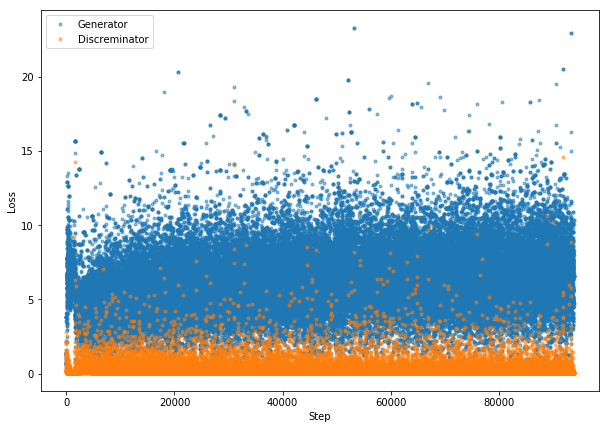

In [6]:
# 预测曲线
plt.figure(figsize = (10, 7))
plt.plot([i[1] for i in results], '.', label = 'Generator', alpha = 0.5)
plt.plot([i[0] for i in results], '.', label = 'Discreminator', alpha = 0.5)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

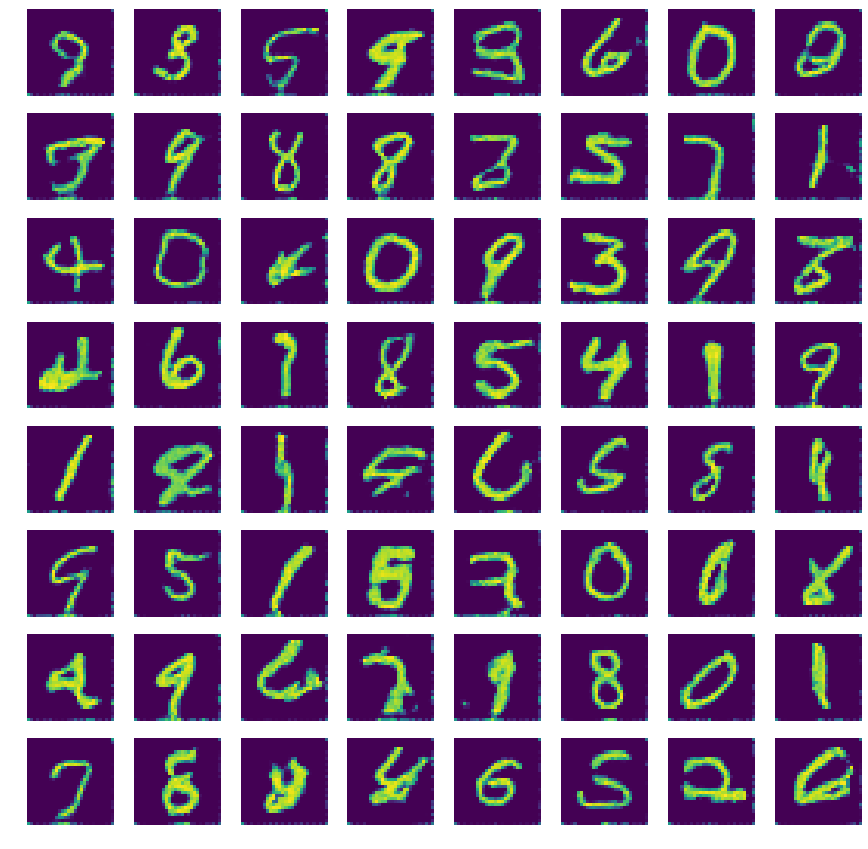

In [7]:
# 绘制一些样本
noise = torch.FloatTensor(batch_size, input_dim, 1, 1)
noise.data.normal_(0,1)
noise = noise.cuda() if use_cuda else noise
sample_size = batch_size
netG.eval()
fake_u = netG(noise)
fake_u = fake_u.cpu() if use_cuda else fake_u
noise = noise.cpu() if use_cuda else samples
img = fake_u #.expand(sample_size, 3, image_size, image_size) #将张量转化成可绘制的图像
#print(img.size())
f, axarr = plt.subplots(8,8, sharex=True, figsize=(15,15))
for i in range(batch_size):
    axarr[i // 8, i % 8].axis('off')
    imshow(img[i].data, None,axarr[i // 8, i % 8])

In [8]:
from pathlib import Path
import zipfile
img_root = Path("/kaggle/working/temp3")
with zipfile.ZipFile('temp3.zip','w') as z:
    for img_name in img_root.iterdir():
        z.write(img_name)